In [3]:
import nlcc
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
base_colors = ["e63946","f1faee","a8dadc","457b9d","1d3557"]
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })

## Load Prompts

In [4]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [5]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [6]:
df.groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,11,11,11,11,11
cheminf,10,10,10,10,10
genchem,11,11,11,11,11
md,9,9,9,9,9
plot,10,10,10,10,10
qm,6,6,6,6,6
sim,4,4,4,4,4
spectroscopy,4,4,4,4,4
stats,10,10,10,10,10


## Programmatic Prompts

In [7]:
paths = ' '.join(valid_files)
temperatures = [0.05, 0.2, 0.5]
k = 5
for i,t in enumerate(temperatures):    
    out = f'override_bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --prompt python --temperature $t
    out = f'bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --temperature $t        
    out = f'insert_bench_{i}.csv'
    !nlcc-bench $paths $out --n $k --prompt insert --temperature $t
    out = f'cheader_bench_{i}.csv'
    header = 'header:# MIT License\n\n# Copyright (c) 2022 University of Rochester\n\n'
    !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t
    out = f'lheader_bench_{i}.csv'
    header = 'header:# This is written by an expert Python programmer\n\n'
    !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t

../data/aa_polarity/aa_polarity.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blast/blast.yml
No module named 'urllib2'
No module named 'urllib2'
No module named 'urllib2'
No module named 'urllib2'
No module named 'urllib2'
../data/bravais/bravais.yml
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, lin

Figure(640x480)
../data/plot_bar/plot_bar.yml
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
../data/plot_contour/plot_contour.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_correlation_coefficient/plot_correlation.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_dual_axis/plot_dual_axis.yml
name 'plt' is not defined
name 'np' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
../data/plot_emoji/plot_emoji.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_outside_legend/plot_outside_legend.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defi

../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
must be real number, not NoneType
must be real number, not NoneType
must be real number, not NoneType
must be real number, not NoneType
must be real number, not NoneType
../data/find_indices/find_indices.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
1.9.5
../data/force-const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
2.25.1
list index out of range
2.25.1
'NoneType' object has no attribute 'find_all'
2.25.1
list index out of range
2.25.1
'NoneType' object has no attribute 'find_all'
2.25.1
list index out of range
../data/hydroph

../data/plot_scatter_pointsize/plot_pointsize.yml
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
../data/plot_sin/plot_sin.yml
../data/plot_sin_polar/plot_sin_polar.yml
../data/pred-interval/pred_interval.yml
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900092
nlcc result: -98.57048973900093
1.7.6
converged SCF energy = -98.5704897

[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
[14:59:06] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[14:59:06] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsE

'Polygon' object has no property 'normed'
'Polygon' object has no property 'normed'
'Polygon' object has no property 'normed'
../data/plot_scatter_pointsize/plot_pointsize.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
../data/plot_sin/plot_sin.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi 

../data/force-const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3

atom_pairs must be between 0 and 36
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be between 0 and 36
atom_pairs must be between 0 and 36
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is re

../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33,

../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will tak

cannot unpack non-iterable NoneType object
module 'urllib' has no attribute 'urlencode'
../data/bravais/bravais.yml
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
../data/canonicalize/canonicalize.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/compare_electronegativity/compare_electronegativity.yml
'Element' object has no attribute 'pauling_electronegativity'
'Element' object has no attribute 'pauling'
../data/descriptors/descriptors.yml
name 'get_descriptor' is not defined
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
unsupported operand type(s) for -: 'float' and 'NoneType'
unsupported operand type(s) for -: 'float' and 'NoneType'
unsupported operand type(s) for -: 'float' and 

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_outside_legend/plot_outside_legend.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_scatter_pointsize/plot_pointsize.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_sin/plot_sin.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_sin_polar/plot_sin_polar.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/pred-interval/pred_interval.yml
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
'NoneType' object is not i

[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Topology' object has no attribute 'residue_names'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
2021.03.2
[15:40:31] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[15:40:31] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
2021.03.2
[15:40:31] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[15:40:31] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'


../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: U

../data/force-const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
list index out of range
list index out of range
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30

<string>:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
<string>:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
name 'cm' is not defined
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot

../data/force-const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
[Errno 2] No such file or directory: 'h2_template.gjf'
../data/genpos/genpos.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
'NoneType' object is not subscriptable
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 

../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
Unrecognized marker style '😀'
<string>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'

'NoneType' object has no attribute 'xyz'
cannot import name '_cast_indices' from 'mdtraj.core.trajectory' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/core/trajectory.py)
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blast/blast.yml
No module named 'urllib2'
No module named 'urllib2'
cannot unpack non-iterable NoneType object
No module named 'urllib2'
[Errno 2] No such file or directory: 'uniprot_sprot.fasta'
../data/bravais/bravais.yml
invalid syntax (<string>, line 30)
No module named 'cctbx'
../data/canonicalize/canonicalize.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling_electronegativity'
'Element' object has no attribute 'en'
'fun

Figure(640x480)
<string>:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
Figure(640x480)
../data/plot_bar/plot_bar.yml
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'plt' is not defined
../data/plot_contour/plot_contour.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_correlation_coefficient/plot_correlation.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_dual_axis/plot_dual_axis.yml
name 'plt' is not 

list index out of range
2.25.1
list index out of range
2.25.1
list index out of range
../data/hydrophobic_res/hydrophobic_res.yml
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
invalid syntax (<string>, line 83)
2021.03.2
[16:27:31] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[16:27:31] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRa

name 'cm' is not defined
[Errno 2] No such file or directory: '/home/ubuntu/output/sin_wave.png'
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😄'
<string>:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😃'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsi

1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (3, 22)
1.9.5
compute_distances() got multiple values for argument 'periodic'
1.9.5
atom_pairs must be ndim 2. You supplied 3
../data/aa_polarity/aa_polarity.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blast/blast.yml
'NoneType' object has no attribute 'text'
list index out of range
'NoneType' object has no attribute 'text'
Error message from NCBI: Message ID#24 Error: Failed to read the Blast query

In [13]:
merged = None
for i,t in enumerate(temperatures):
    f = f'override_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = 'none'
    if merged is None:
        merged = bf
    else:
        merged = pd.concat((merged, bf))
    f = f'bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    merged = pd.concat((merged, bf))
    f = f'insert_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
    f = f'cheader_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
    f = f'lheader_bench_{i}.csv'
    bf = pd.read_csv(f, delim_whitespace=True)    
    bf = pd.merge(bf, df, how='inner', on='name')
    bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
    merged = pd.concat((merged, bf))
def simple_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'
    
merged = merged.assign(used_context=merged.context.apply(simple_context))
merged.to_pickle('promp_results.pkl')
merged.tail()

,name,result,temperature,language,context,topic,type,natlang,used_context
375,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
376,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
377,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
378,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority
379,unbdistance,0,0.5,python,mdtraj-authority,md,code,en,authority


/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


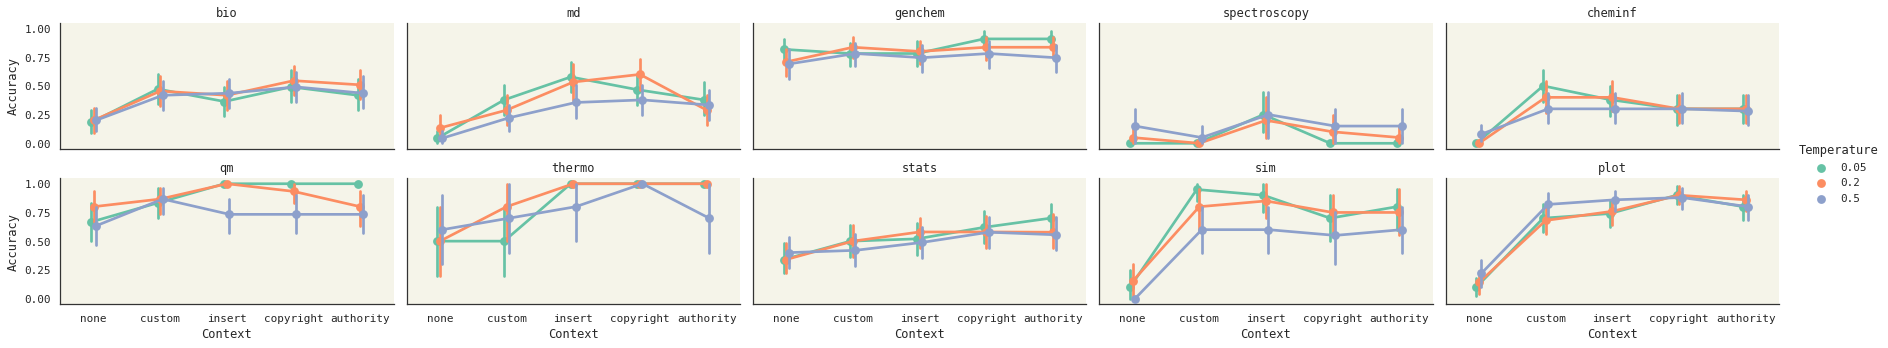

In [14]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='topic', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('accuracy.pdf')

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


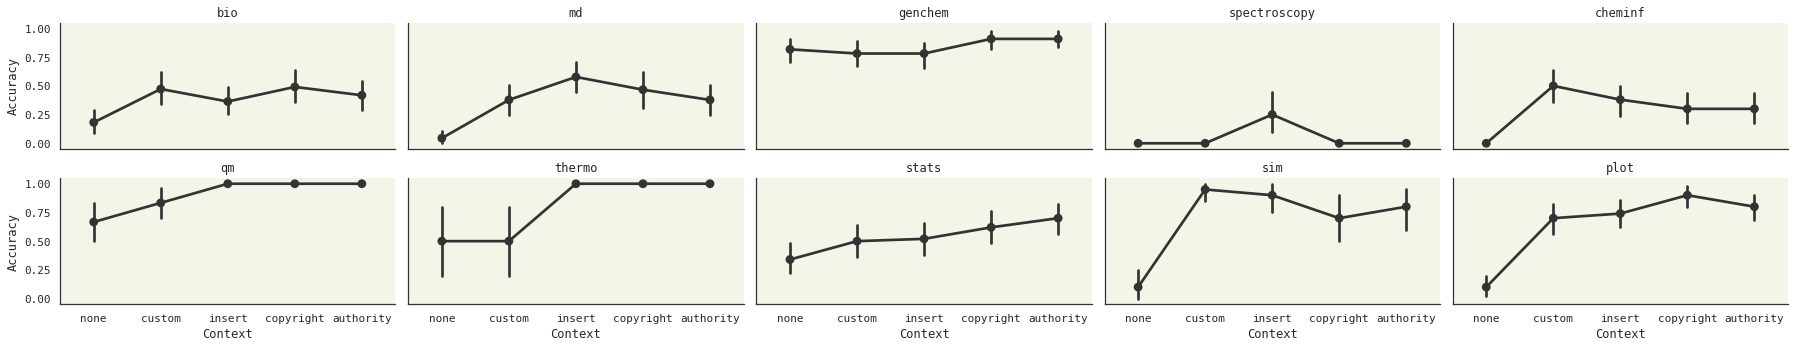

In [15]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged[merged.temperature == 0.05], col='topic',  col_wrap=5, height=2.5, aspect=2)
g.map(sns.pointplot, 'used_context', 'result', dodge=True, color='#333')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('marginal_accuracy.pdf')

In [16]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    11 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &     9 \\
plot         &    10 \\
qm           &     6 \\
sim          &     4 \\
spectroscopy &     4 \\
stats        &    10 \\
thermo       &     2 \\
\bottomrule
\end{tabular}



/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


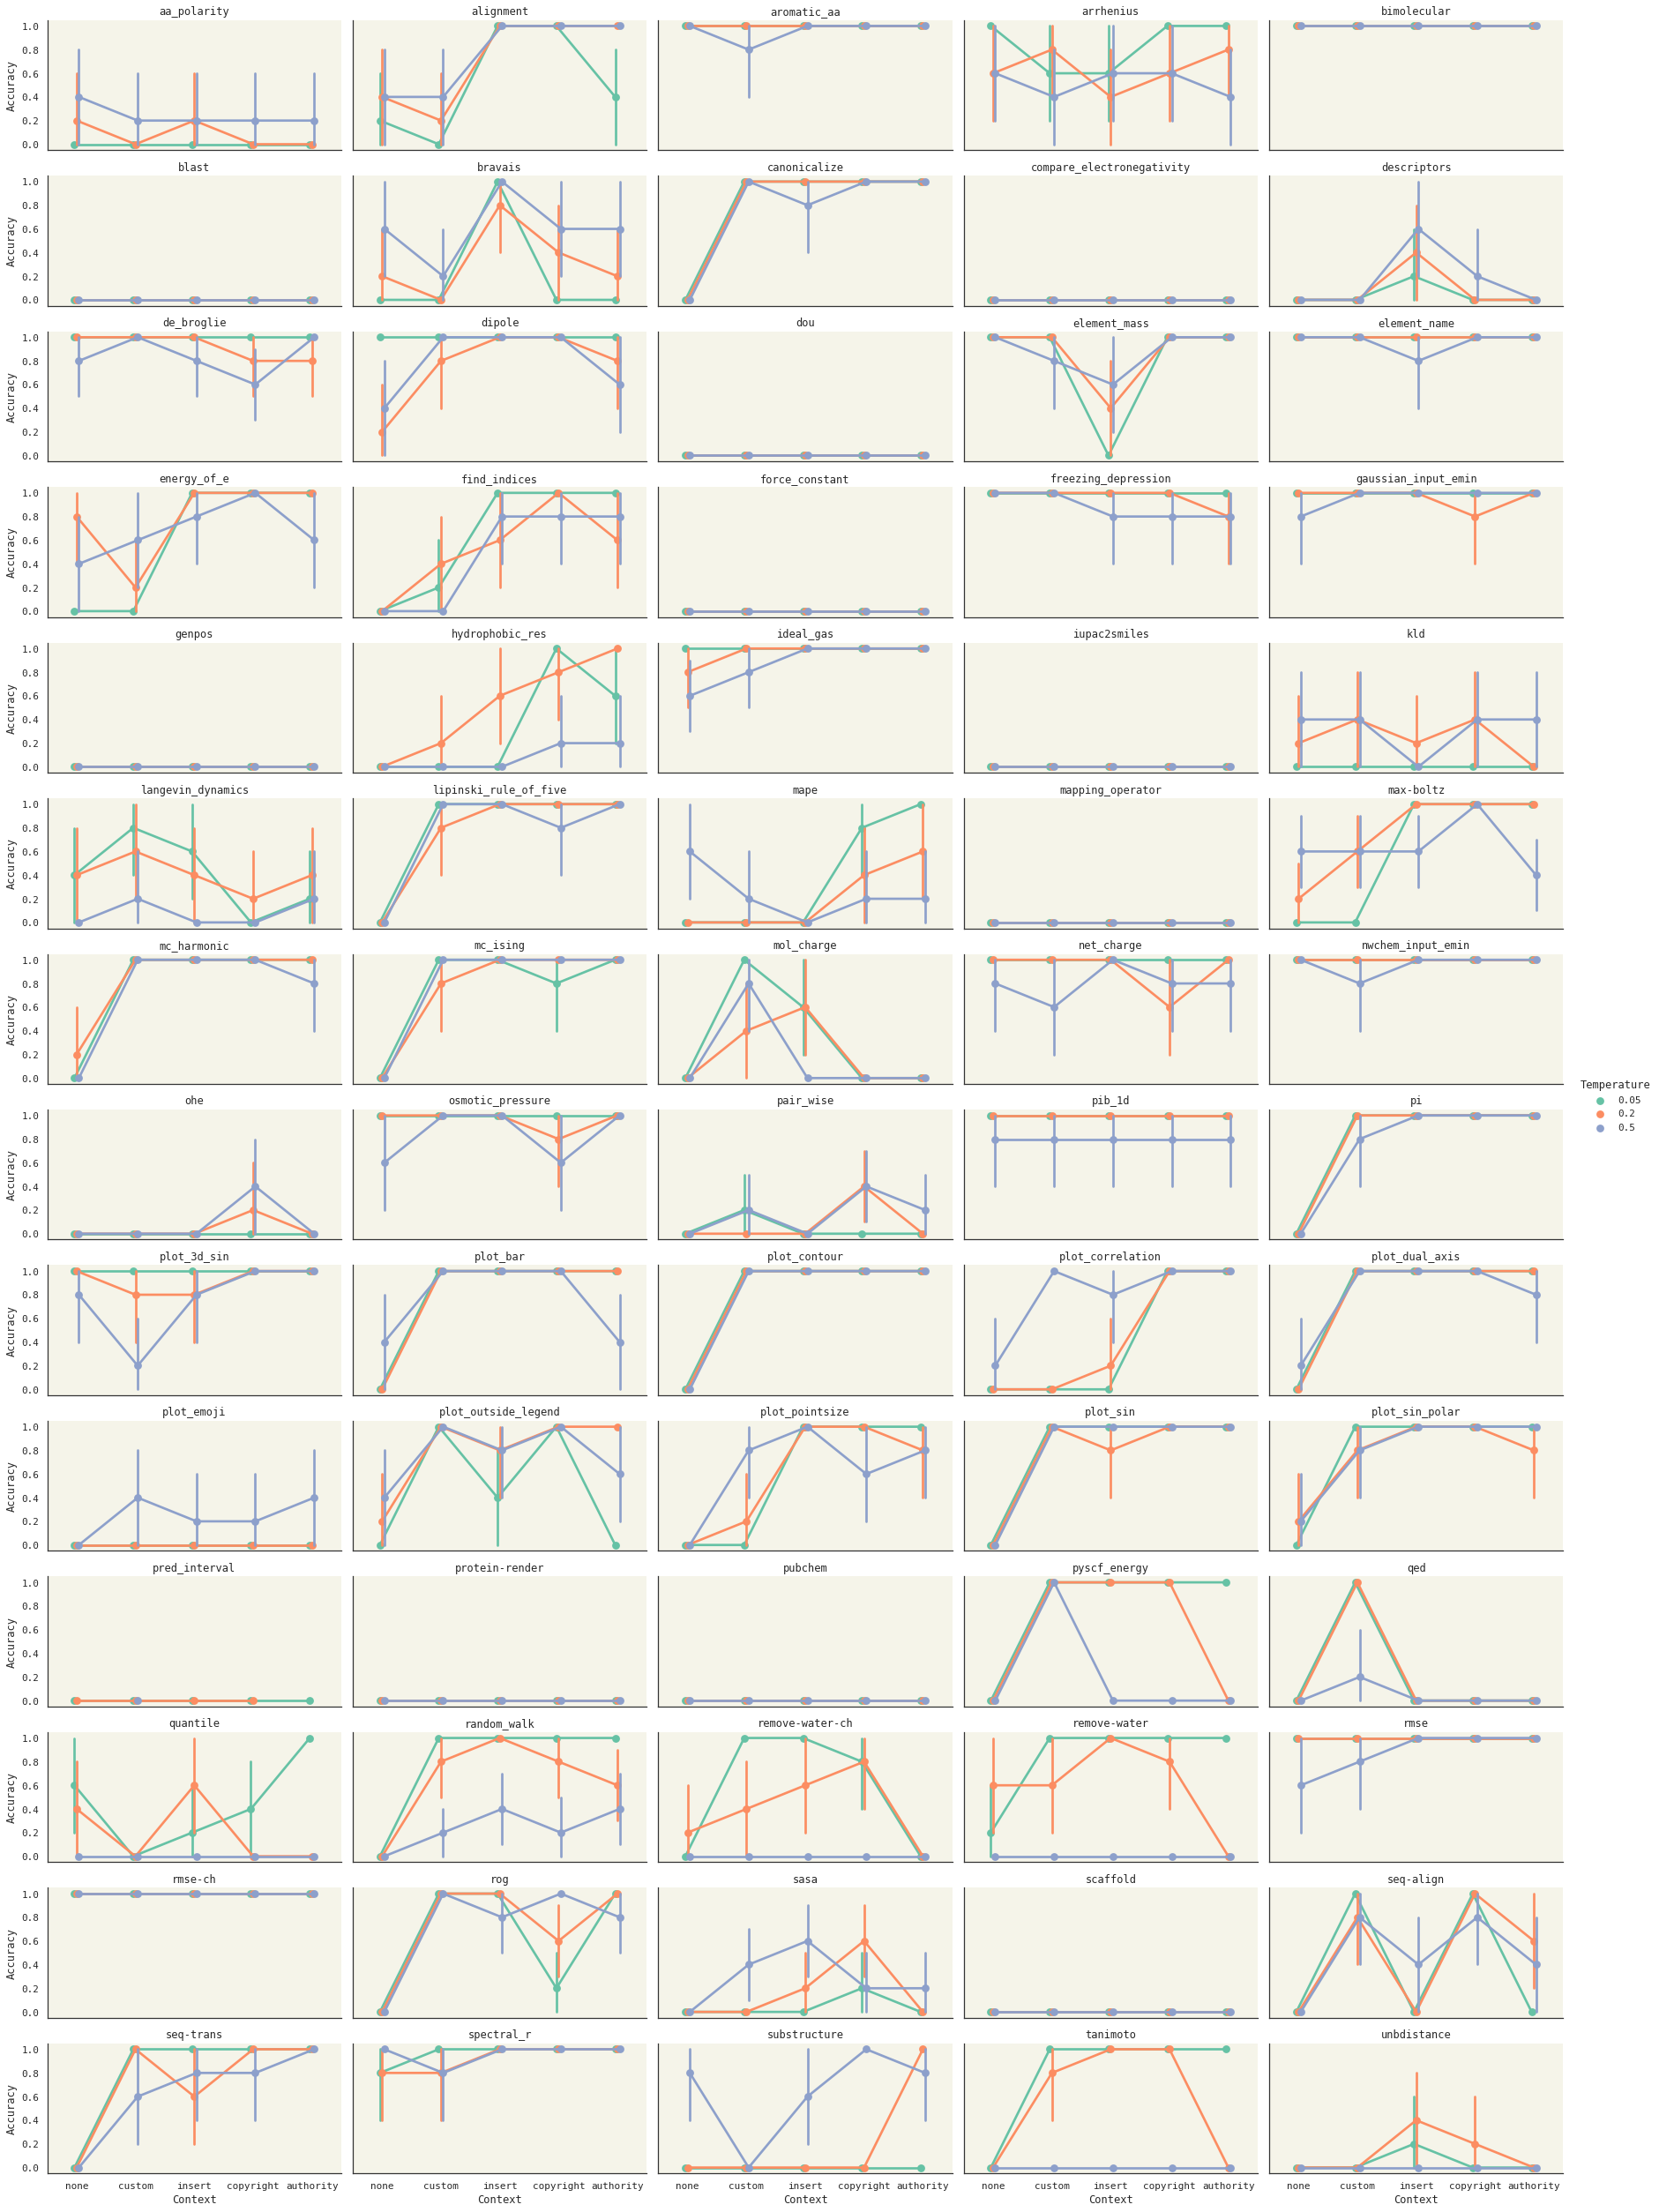

In [17]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('all.pdf')